In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
original_df = pd.read_csv('/content/drive/MyDrive/WineQT.csv')

In [ ]:
train_df.info()
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
D

In [ ]:
full_train= pd.concat([train_df,original_df])
full_train.drop('Id',axis=1, inplace= True)
full_train.shape

(3199, 12)

In [ ]:
#Statistics describtion
full_train.describe().iloc[1:,:-1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
mean,8.345858,0.528936,0.266239,2.446499,0.08367,16.477024,48.049859,0.996742,3.310728,0.647168,10.424669
std,1.720511,0.175484,0.191294,1.065161,0.03414,10.115222,32.930681,0.001863,0.147582,0.150524,1.048119
min,4.600000,0.120000,0.000000,0.900000,0.01200,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.07100,7.000000,22.000000,0.995580,3.200000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.07900,15.000000,42.000000,0.996700,3.310000,0.620000,10.100000
75%,9.100000,0.640000,0.420000,2.600000,0.09000,23.000000,64.000000,0.997800,3.390000,0.720000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.61100,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [ ]:
full_train['quality'].value_counts()

5    1322
6    1240
7     476
4      88
8      55
3      18
Name: quality, dtype: int64

In [ ]:
quality_corr = full_train.corr()['quality'][:-1].sort_values(ascending=False) # -1 means that the latest row is quality
print(quality_corr) #displays pearsons correlation coefficient

alcohol                 0.482102
sulphates               0.318649
citric acid             0.176236
fixed acidity           0.091092
residual sugar          0.032871
pH                     -0.008851
free sulfur dioxide    -0.058752
chlorides              -0.082893
density                -0.160544
total sulfur dioxide   -0.208935
volatile acidity       -0.285484
Name: quality, dtype: float64


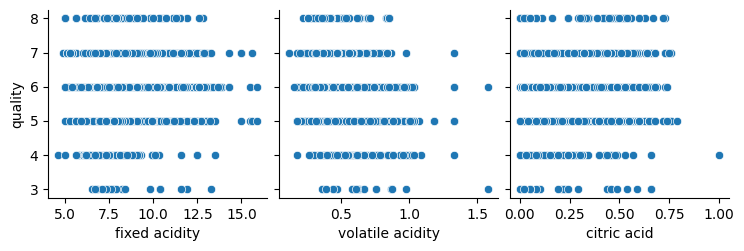

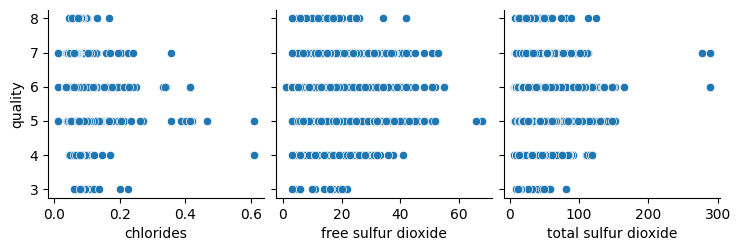

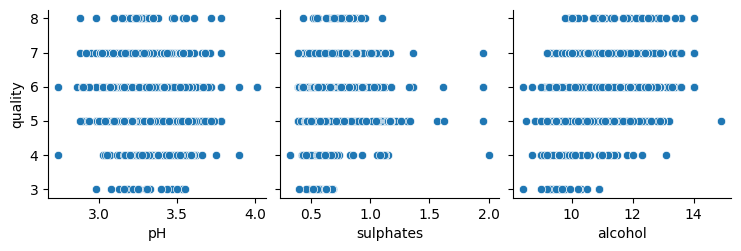

In [ ]:
for i in range(0, len(full_train.columns[:-1]),4):
    sns.pairplot(data=full_train,
                x_vars=full_train.columns[i:i+3],
                y_vars=['quality'])

In [ ]:
len(full_train.columns)

12

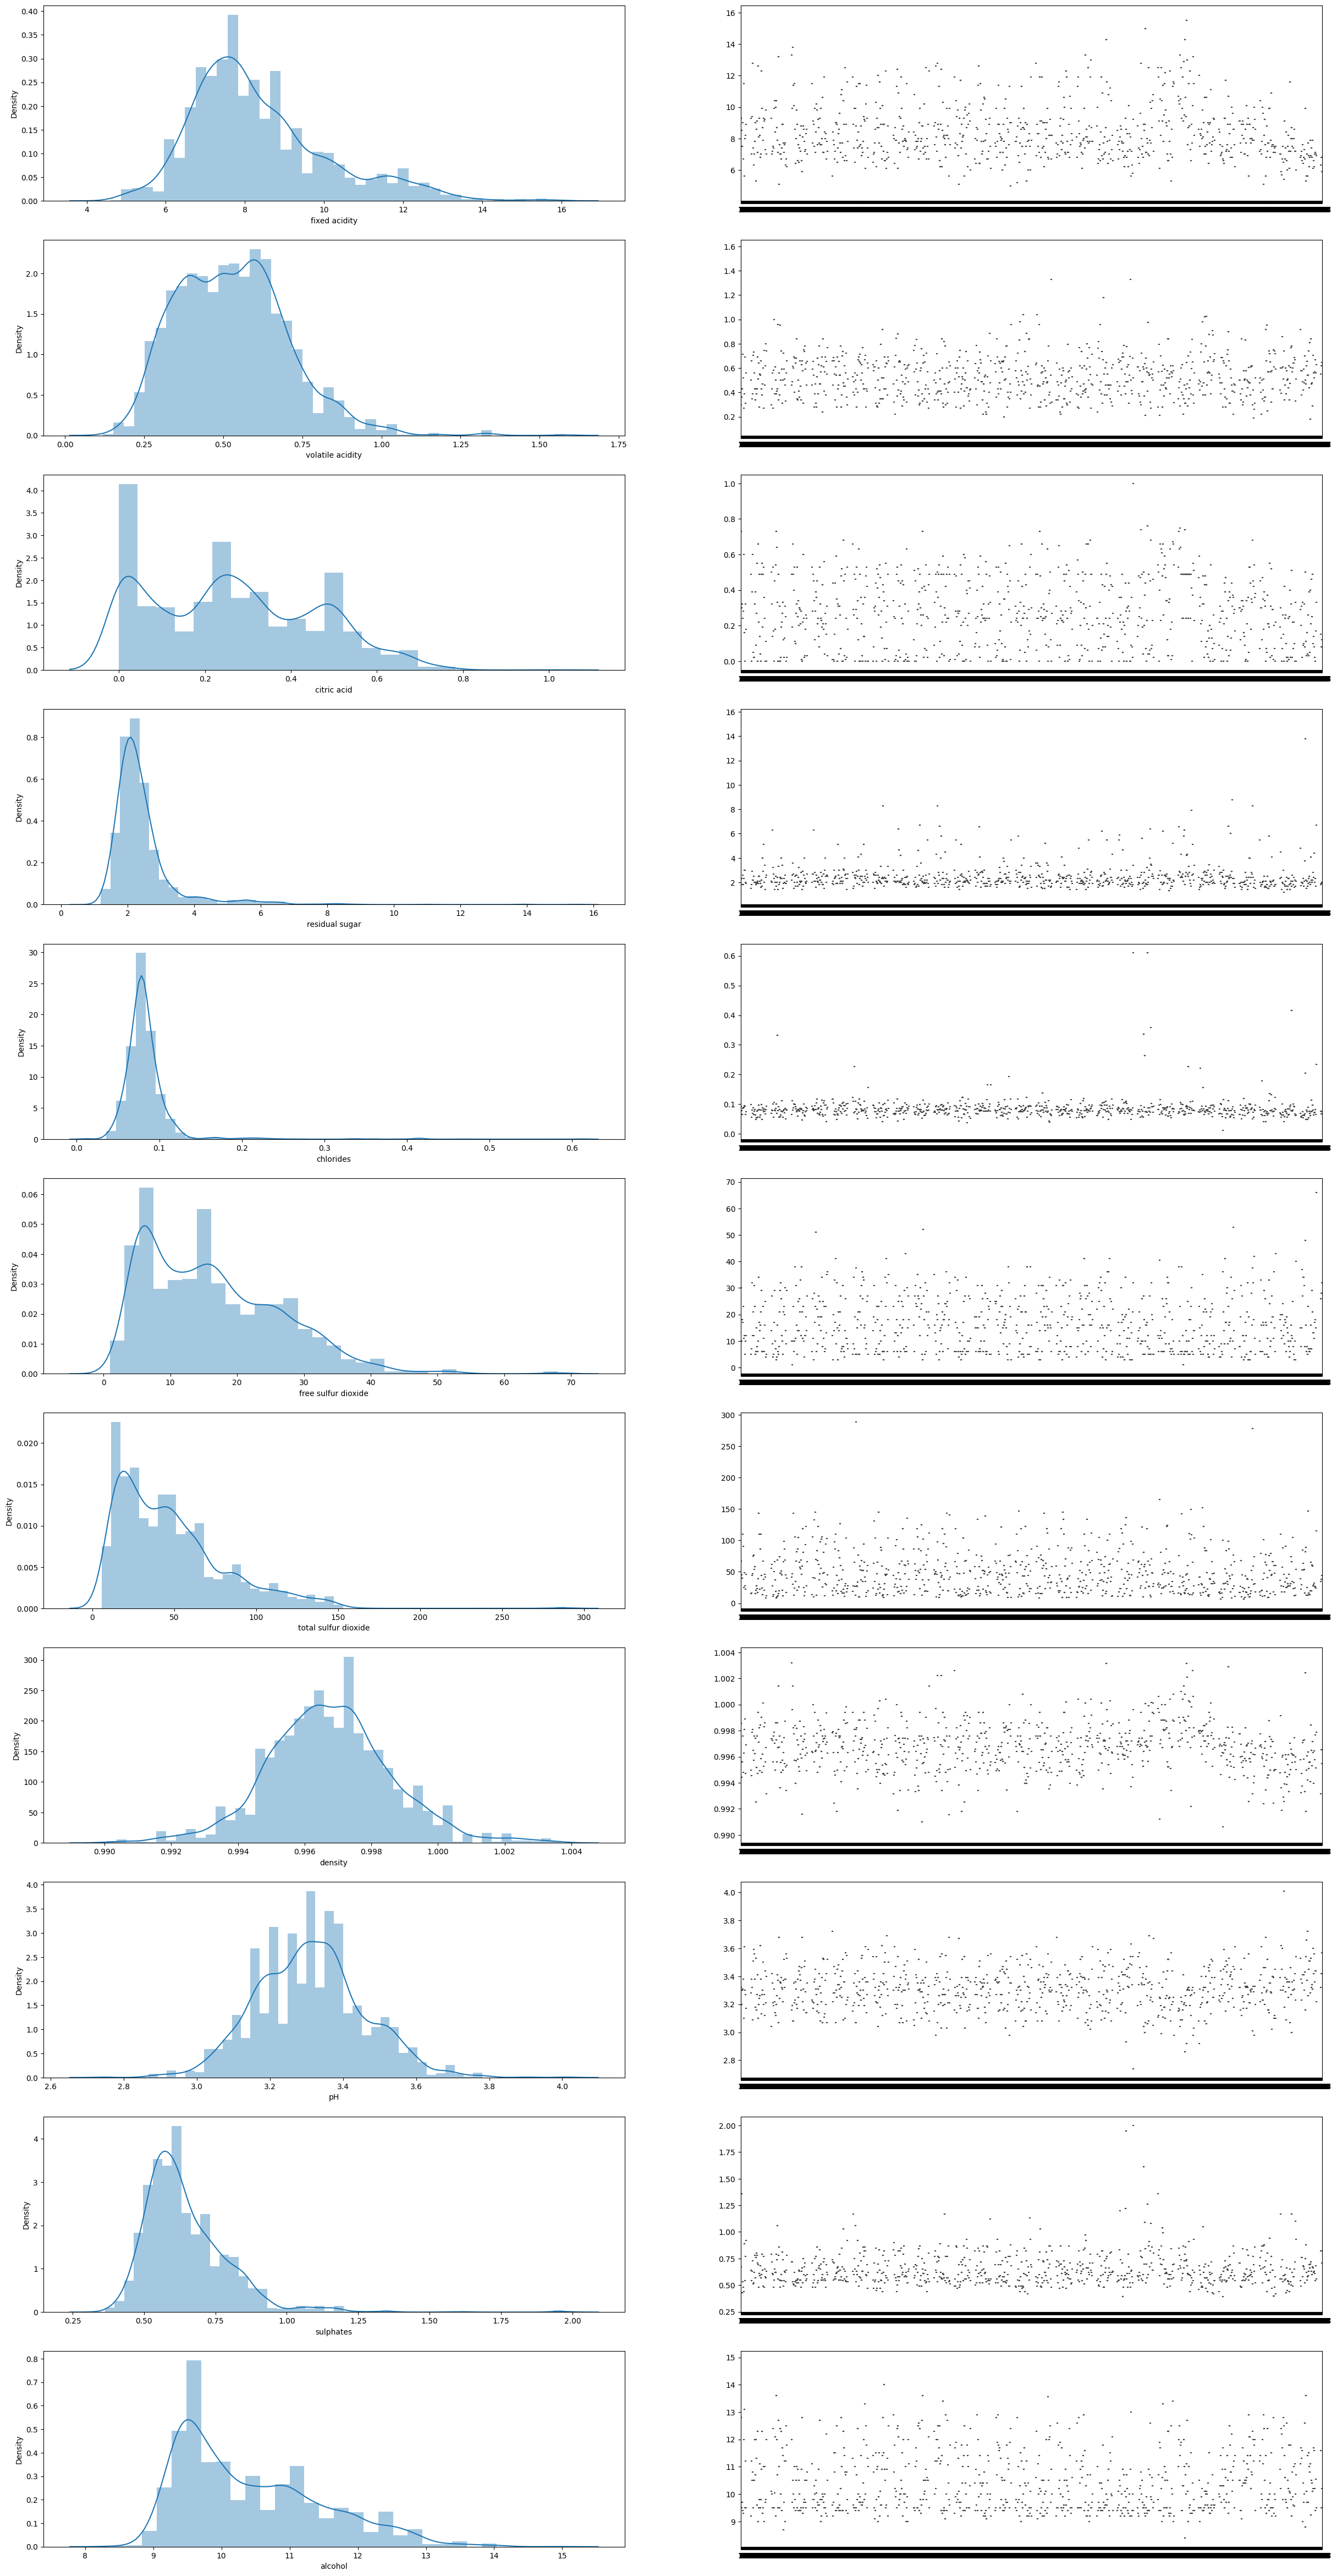

In [ ]:
fig,ax = plt.subplots(11,2,figsize=(30,60))
for index,i in enumerate(full_train.columns[:-1]):
    sns.distplot(full_train[i],ax=ax[index,0])
    sns.boxplot(full_train[i],ax=ax[index,1])

In [ ]:
skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = full_train.skew()
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
chlorides,6.986836
residual sugar,4.557520
sulphates,2.216731
total sulfur dioxide,1.403604
fixed acidity,0.989993
free sulfur dioxide,0.876612
alcohol,0.818845


In [ ]:
y= full_train['quality']
X= full_train.drop(['quality'],axis=1)

In [ ]:
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(X)

In [ ]:
#scale feature using minmax scaler approche
X_train, X_test, y_train, y_test = train_test_split(scaled,y,train_size=0.8, test_size=0.2, random_state=1234)
X_train.shape, X_test.shape

((2559, 11), (640, 11))

In [ ]:
models = [RandomForestClassifier(), KNeighborsClassifier(), svm.SVC(), LogisticRegression(),DecisionTreeClassifier()]
scores = dict()

for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    print(f'model: {str(m)}')
    print(classification_report(y_test,y_pred, zero_division=1))
    print('-'*30, '\n')

model: RandomForestClassifier()
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         2
           4       1.00      0.00      0.00        18
           5       0.72      0.77      0.74       271
           6       0.57      0.65      0.61       242
           7       0.51      0.38      0.43        96
           8       1.00      0.09      0.17        11

    accuracy                           0.63       640
   macro avg       0.80      0.31      0.33       640
weighted avg       0.64      0.63      0.61       640

------------------------------ 

model: KNeighborsClassifier()
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         2
           4       0.00      0.00      0.00        18
           5       0.61      0.69      0.65       271
           6       0.47      0.54      0.50       242
           7       0.46      0.26      0.33        96
           8       1.00      0.00    

In [ ]:
def Prune_model(grid, model):
    gcv = GridSearchCV(estimator = model, param_grid = grid,cv = 3, n_jobs = -1)
    gcv.fit(X_train, y_train)
    print(gcv.best_params_)
    return gcv

In [ ]:
grid = {'max_depth': range(1, 20),
         'min_samples_split': [2, 3, 4],
         'min_samples_leaf': range(1, 7)}

ct_model = DecisionTreeClassifier(random_state = 1234)
ct_grid = Prune_model(grid,ct_model)
ct_grid.score(X_train, y_train),ct_grid.score(X_test, y_test)

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


(0.6111762407190309, 0.6046875)

In [ ]:
random_grid={'max_depth': range(7,14),
             'min_samples_leaf': [1, 2],
             'min_samples_split': [4,7],
             'n_estimators': [250,300,350]}
rf_model = RandomForestClassifier()
rf_grid = Prune_model(random_grid, rf_model)
rf_grid.score(X_train, y_train),rf_grid.score(X_test, y_test)

{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 350}


(0.8522860492379836, 0.6171875)

In [ ]:
k_grid={'leaf_size': range(1,20),
        'p': [1,2],
        'n_neighbors': range(1,21,3)}
k_model = KNeighborsClassifier()
k_grid_model= Prune_model(k_grid, k_model)
k_grid_model.score(X_train, y_train),k_grid_model.score(X_test, y_test)

{'leaf_size': 1, 'n_neighbors': 13, 'p': 1}


(0.627979679562329, 0.5578125)

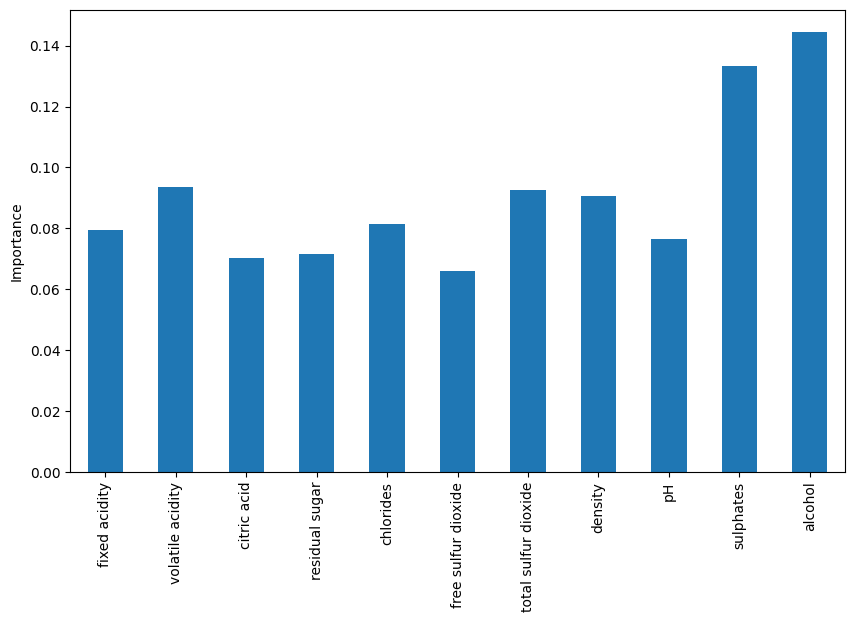

In [ ]:
rf_model.fit(X_train, y_train)
importance = rf_model.feature_importances_
feature_importance = pd.Series(importance, index = full_train.drop(['quality'],axis=1).columns)
feature_importance.plot(kind = 'bar',figsize=(10,6))
plt.ylabel('Importance');

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_data= test_df.drop('Id',axis=1)
prediction= rf_grid.predict(test_data)
output = pd.DataFrame({'Id': test_df.Id, 'quality': prediction})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
